# 集成算法
- 目的：提高模型的准确率
- bagging: 通过多个模型的预测结果进行投票，最终结果由多数决定. $\hat{f}(x) = \frac{1}{M} \sum_{m=1}^{M} f_m(x)$
- boosting: 通过多个模型的预测结果进行加权投票，最终结果由加权多数决定.
    - $F_m(x) = F_{m-1}(x) + argmin_{h} \sum_{i=1}^{N} L(y_i, F_{m-1}(x_i) + h(x_i))$ (加入一颗树,会让模型更强)
- stacking: 聚合多个模型的预测结果，通过一个元模型进行预测

## bagging
- 全称: Bootstrap aggregating(并行训练很多分类器，然后平均)
- 通过自助采样，生成多个训练集，训练多个模型，最终结果由多数决定
- 代表模型：随机森林
    - 随机:数据随机采样，特征随机采样(或者按照gini系数选择特征)
    - 森林:多个决策树
- 优势:
    - 高维数据,不用做特征选择
    - 完成后，可以给出各个特征的重要性
    - 训练速度快
    - 可以并行训练
- 缺点:
    - 预测速度慢
    - 有些时候不够准确
- 树的个数: 通过交叉验证确定
    - 理论上，树的个数越多，模型越好，但是到一定程度，就会上下波动了
    - 通过交叉验证，找到最优的树的个数

## boosting
- 全程: Boosting(串联训练多个分类器，然后加权平均)
- 通过多个模型的预测结果进行加权投票，最终结果由加权多数决定.
- 代表模型: adaboost, XGBoost (LightGBM, GBDT)
- adaboost: 根据上一次的错误率，调整样本权重，训练下一个模型
- XGBoost: 根据上一次的残差，训练下一个模型


## stacking
- 全称: Stacked generalization
- 通过多个模型的预测结果进行加权投票，最终结果由加权多数决定.

In [2]:
import numpy as np
import os
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

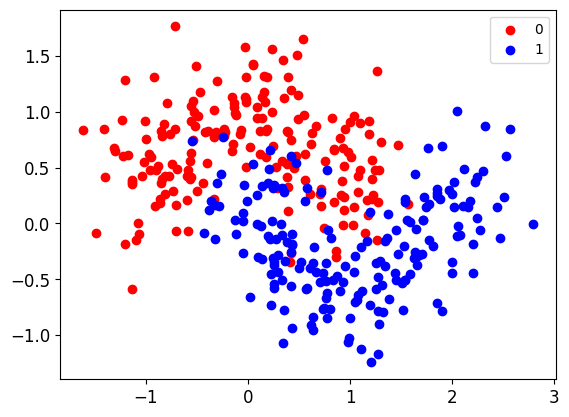

In [4]:
plt.scatter(X_train[y_train==0][:, 0], X_train[y_train==0][:, 1], c='r', label='0')
plt.scatter(X_train[y_train==1][:, 0], X_train[y_train==1][:, 1], c='b', label='1')
plt.legend()
plt.show()


### 投票策略: 硬投票和软投票
- 硬投票: 多个模型投票，多数决定
- 软投票: 多个模型投票，加权多数决定

### 硬投票

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42)

voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)], voting='hard')
voting_clf.fit(X_train, y_train)


VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [6]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__,
            accuracy_score(y_test, y_pred))
    


LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


### 软投票

In [7]:
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(probability=True,random_state=42)

voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)], voting='soft')

In [8]:
voting_clf.fit(X_train, y_train)


VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [9]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__,
            accuracy_score(y_test, y_pred))


LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


## bagging
- 对数据进行多次采样，保证每次采样的数据集不同
- 分别训练多个模型，例如决策树
- 预测时，多个模型投票，多数决定(集成)
- 

In [10]:
X_train.shape

(375, 2)

In [11]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=100, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.92


In [12]:
tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.848


### 决策边界

In [13]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=(-1.5, 2.5, -1, 1.5), alpha=0.6, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "ro", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

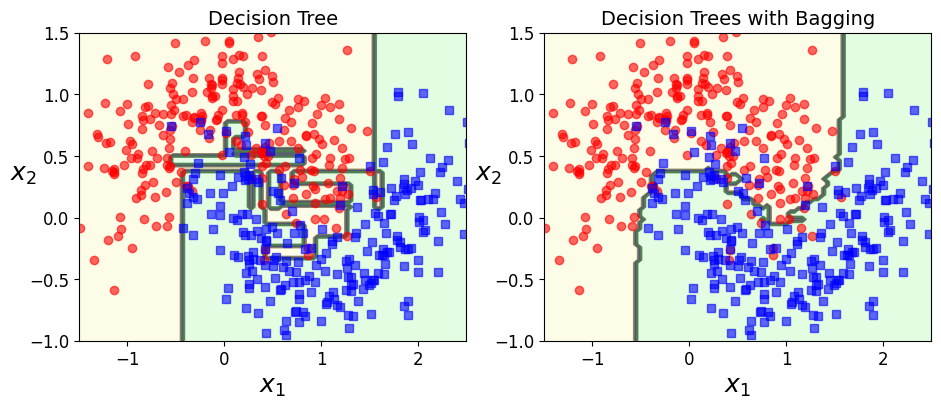

In [14]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.show()

### OOB
- out-of-bag

In [15]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), 
                            n_estimators=500, 
                            max_samples=100,
                            bootstrap=True, 
                            n_jobs=-1, 
                            oob_score=True)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.9226666666666666

In [16]:
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

In [17]:
bag_clf.oob_decision_function_

array([[0.28532609, 0.71467391],
       [0.43421053, 0.56578947],
       [1.        , 0.        ],
       [0.01055409, 0.98944591],
       [0.02624672, 0.97375328],
       [0.07853403, 0.92146597],
       [0.44072165, 0.55927835],
       [0.06544503, 0.93455497],
       [0.94736842, 0.05263158],
       [0.84636119, 0.15363881],
       [0.58205128, 0.41794872],
       [0.06299213, 0.93700787],
       [0.71957672, 0.28042328],
       [0.85676393, 0.14323607],
       [0.92639594, 0.07360406],
       [0.07936508, 0.92063492],
       [0.04336043, 0.95663957],
       [0.94565217, 0.05434783],
       [0.6460396 , 0.3539604 ],
       [0.97282609, 0.02717391],
       [0.05181347, 0.94818653],
       [0.27631579, 0.72368421],
       [0.88888889, 0.11111111],
       [0.99488491, 0.00511509],
       [0.95090439, 0.04909561],
       [0.0027027 , 0.9972973 ],
       [0.97319035, 0.02680965],
       [0.9947644 , 0.0052356 ],
       [0.02610966, 0.97389034],
       [0.7459893 , 0.2540107 ],
       [0.

### 随机森林
- bagging的一个扩展
- 

### 特征重要性
sklearn是看特征在树中的深度，来判断特征的重要性

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris

iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris['data'], iris['target'])
for name, score in zip(iris.feature_names, rnd_clf.feature_importances_):
    print(name, score)  


sepal length (cm) 0.08981492192792313
sepal width (cm) 0.024169783112696016
petal length (cm) 0.44427700278947496
petal width (cm) 0.4417382921699059


Mnist中哪些特征重要

In [19]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
rnd_clf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rnd_clf.fit(mnist['data'], mnist['target'])

RandomForestClassifier(n_jobs=-1)

In [20]:
rnd_clf.feature_importances_.shape

(784,)

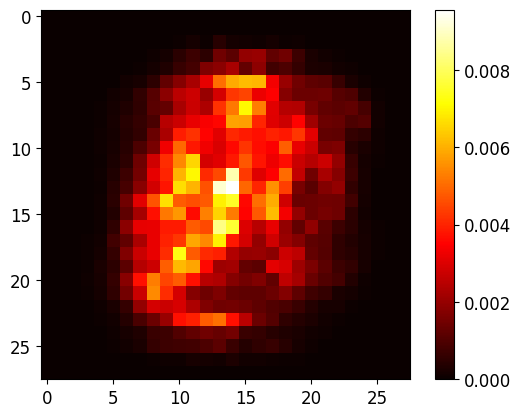

In [21]:
import matplotlib.pyplot as plt
plt.imshow(rnd_clf.feature_importances_.reshape(28, 28), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()


## Boosting

### Adaboost
- 根据上一次的错误率，调整样本权重，训练下一个模型

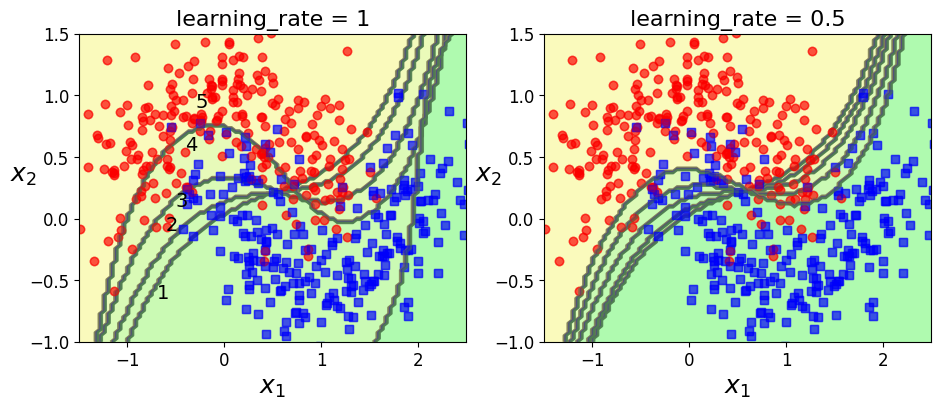

In [22]:
from sklearn.svm import SVC


m = len(X_train)
plt.figure(figsize=(11, 4))

for subplot, learning_rate in ((121, 1), (122, 0.5)):
    sample_weights = np.ones(m)
    plt.subplot(subplot)
    for i in range(5):
        svm_clf = SVC(kernel='rbf', C=0.05, gamma='auto', random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title('learning_rate = {}'.format(learning_rate), fontsize=16)
    if subplot == 121:
        plt.text(-0.7, -0.65, '1', fontsize=14)
        plt.text(-0.6, -0.10, '2', fontsize=14)
        plt.text(-0.5,  0.10, '3', fontsize=14)
        plt.text(-0.4,  0.55, '4', fontsize=14)
        plt.text(-0.3,  0.90, '5', fontsize=14)
        

plt.show()

In [23]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200, algorithm='SAMME.R', learning_rate=0.5,
                             random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

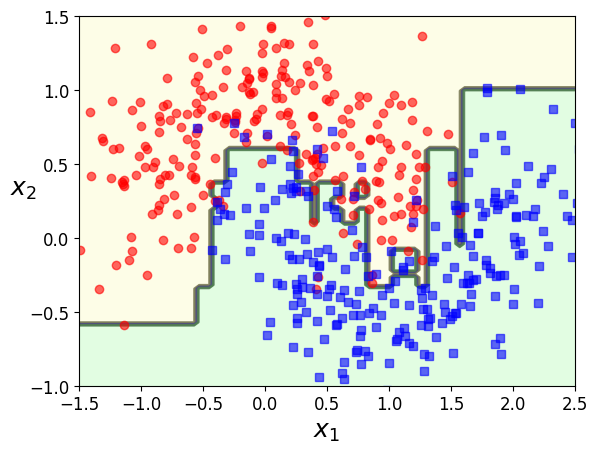

In [24]:
plot_decision_boundary(ada_clf, X, y)

### Gradient Boosting
- GBDT: Gradient Boosting Decision Tree
- XGBoost: eXtreme Gradient Boosting
- LightGBM: Light Gradient Boosting Machine

In [25]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)


In [26]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)


DecisionTreeRegressor(max_depth=2)

In [27]:
tree_reg1.predict(X)

array([0.12356613, 0.52856846, 0.12356613, 0.12356613, 0.12356613,
       0.12356613, 0.66091233, 0.52856846, 0.12356613, 0.12356613,
       0.66091233, 0.52856846, 0.52856846, 0.12356613, 0.12356613,
       0.12356613, 0.12356613, 0.12356613, 0.12356613, 0.12356613,
       0.12356613, 0.48779682, 0.12356613, 0.12356613, 0.12356613,
       0.12356613, 0.12356613, 0.12356613, 0.12356613, 0.66091233,
       0.12356613, 0.12356613, 0.66091233, 0.52856846, 0.52856846,
       0.12356613, 0.12356613, 0.48779682, 0.12356613, 0.12356613,
       0.48779682, 0.12356613, 0.66091233, 0.52856846, 0.12356613,
       0.12356613, 0.12356613, 0.12356613, 0.12356613, 0.12356613,
       0.52856846, 0.12356613, 0.52856846, 0.52856846, 0.12356613,
       0.52856846, 0.48779682, 0.12356613, 0.66091233, 0.12356613,
       0.12356613, 0.12356613, 0.52856846, 0.12356613, 0.12356613,
       0.12356613, 0.12356613, 0.12356613, 0.48779682, 0.52856846,
       0.12356613, 0.12356613, 0.66091233, 0.12356613, 0.12356

In [28]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2)

In [29]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2)

In [30]:
X_new = np.array([[0.8]])
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
y_pred

array([0.75026781])

In [31]:
def plot_predictions(regressors, X, y, axes, label=None, style='r-', data_style='b.', data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc='upper center', fontsize=16)
    plt.axis(axes)
    

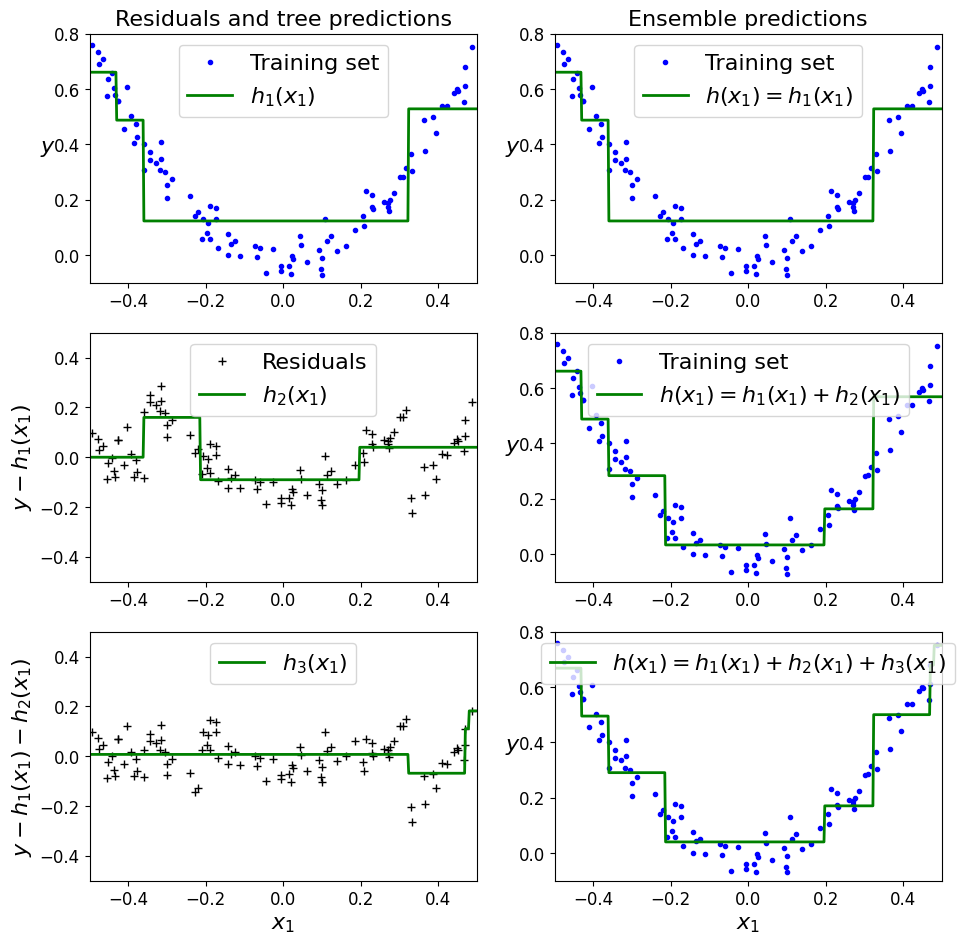

In [32]:
plt.figure(figsize=(11, 11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label='$h_1(x_1)$', style='g-', data_label='Training set')
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.title('Residuals and tree predictions', fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label='$h(x_1) = h_1(x_1)$', style='g-', data_label='Training set')
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.title('Ensemble predictions', fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label='$h_2(x_1)$', style='g-', data_style='k+', data_label='Residuals')
plt.ylabel('$y - h_1(x_1)$', fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label='$h(x_1) = h_1(x_1) + h_2(x_1)$', style='g-', data_label='Training set')
plt.ylabel('$y$', fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label='$h_3(x_1)$', style='g-', data_style='k+')
plt.ylabel('$y - h_1(x_1) - h_2(x_1)$', fontsize=16)
plt.xlabel('$x_1$', fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label='$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$', style='g-')
plt.xlabel('$x_1$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)

plt.show()

In [33]:
from sklearn.ensemble import GradientBoostingRegressor

gbdt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbdt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

In [34]:
gbdt.predict(X_new)


array([0.75026781])

In [35]:
gbdt_slow1 = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=0.1, random_state=42)
gbdt_slow1.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=3, random_state=42)

In [36]:
gbdt_slow2 = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbdt_slow2.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

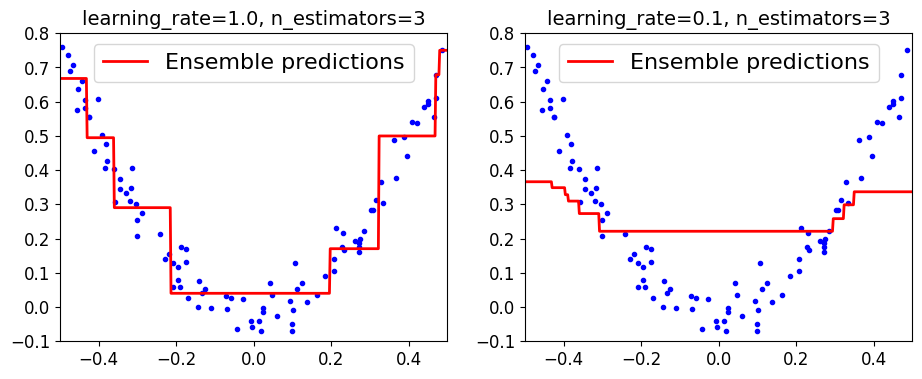

In [37]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plot_predictions([gbdt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label='Ensemble predictions')
plt.title('learning_rate={}, n_estimators={}'.format(gbdt.learning_rate, gbdt.n_estimators), fontsize=14)

plt.subplot(122)
plot_predictions([gbdt_slow1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label='Ensemble predictions')
plt.title('learning_rate={}, n_estimators={}'.format(gbdt_slow1.learning_rate, gbdt_slow1.n_estimators), fontsize=14)
plt.show()

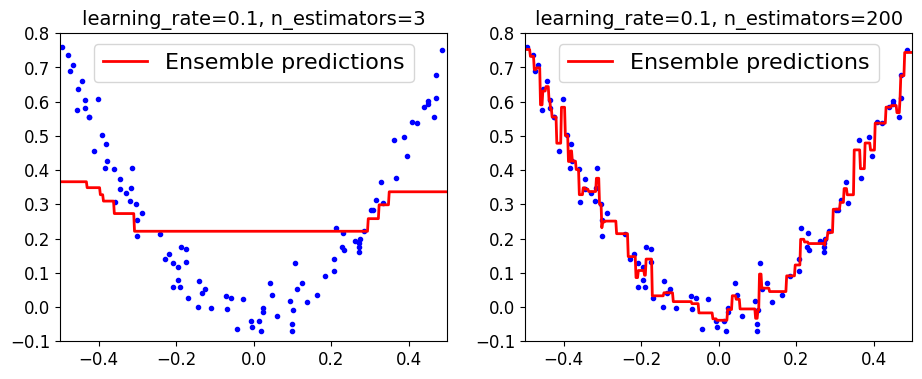

In [38]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plot_predictions([gbdt_slow1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label='Ensemble predictions')
plt.title('learning_rate={}, n_estimators={}'.format(gbdt_slow1.learning_rate, gbdt_slow1.n_estimators), fontsize=14)

plt.subplot(122)
plot_predictions([gbdt_slow2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label='Ensemble predictions')
plt.title('learning_rate={}, n_estimators={}'.format(gbdt_slow2.learning_rate, gbdt_slow2.n_estimators), fontsize=14)
plt.show()


### 提前停止策略

In [39]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

In [40]:
gbdt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbdt.fit(X_train, y_train)

from sklearn.metrics import mean_squared_error
errors = [mean_squared_error(y_val, y_pred) for y_pred in gbdt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1


In [41]:
gbdt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)

In [42]:
gbdt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=np.int64(56),
                          random_state=42)

In [43]:
min_error = np.min(errors)
min_error

np.float64(0.002712853325235463)

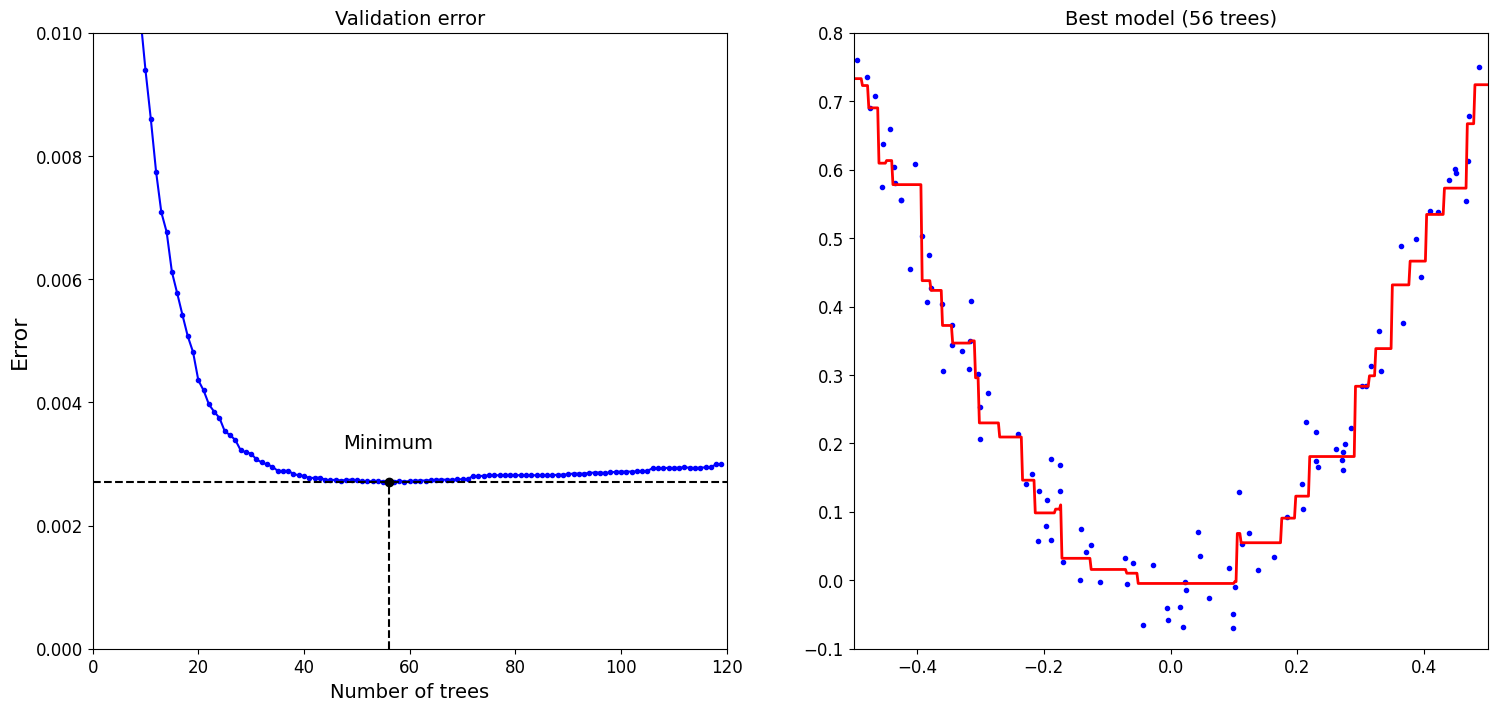

In [44]:
plt.figure(figsize=(18, 8))
plt.subplot(121)
plt.plot(errors, 'b.-')
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], 'k--')
plt.plot([0, 120], [min_error, min_error], 'k--')
plt.plot(bst_n_estimators, min_error, 'ko')
plt.text(bst_n_estimators, min_error*1.2, 'Minimum', ha='center', fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel('Number of trees')
plt.ylabel('Error', fontsize=16)
plt.title('Validation error', fontsize=14)

plt.subplot(122)
plot_predictions([gbdt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title('Best model (%d trees)' % bst_n_estimators, fontsize=14)

plt.show()

In [45]:
gbdt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)
min_error = float('inf')

In [46]:
for n_estimators in range(1, 120):
    gbdt.n_estimators = n_estimators
    gbdt.fit(X_train, y_train)
    y_pred = gbdt.predict(X_val)
    error = mean_squared_error(y_val, y_pred)
    if error < min_error:
        min_error = error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break

In [47]:
print(gbdt.n_estimators)

61


### Stacking(堆叠法)

In [48]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

mnist = fetch_openml('mnist_784', version=1)
 
X_train_val, X_test, y_train_val, y_test = train_test_split(mnist['data'], mnist['target'], test_size=10000, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=10000, random_state=42) 

In [49]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

In [50]:
random_forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
extra_trees_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)
svm_clf = LinearSVC(random_state=42)
mlp_clf = MLPClassifier(random_state=42)

estimators = [random_forest_clf, extra_trees_clf, svm_clf, mlp_clf]

In [51]:
X_val_predictions = np.empty((len(X_val), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    estimator.fit(X_train, y_train)
    y_val_predict = estimator.predict(X_val)
    X_val_predictions[:, index] = y_val_predict
    

In [52]:
X_val_predictions

array([[5., 5., 5., 5.],
       [8., 8., 8., 8.],
       [2., 2., 2., 2.],
       ...,
       [7., 7., 7., 7.],
       [6., 6., 6., 6.],
       [7., 7., 7., 7.]], dtype=float32)

In [53]:
rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)
rnd_forest_blender.fit(X_val_predictions, y_val)

RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)

In [54]:
rnd_forest_blender.oob_score_

0.9687